In [1]:
#start from https://gist.github.com/yuchenlin/eb63e2d0513f70cfc9bb85fa5a78953b

import torch
#from transformers import OpenAIGPTTokenizer, OpenAIGPTLMHeadModel
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoModelWithLMHead, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def word_ent(model_tokenizer, text, cuda):
    top_k_val = 5
    model = model_tokenizer[0]
    tokenizer = model_tokenizer[1]
    assert model is not None
    assert tokenizer is not None
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    input_ids = input_ids.to(model.device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss, logits = outputs[:2]
    probs = logits.softmax(dim=-1)
    #print(probs)
    ent = - (probs * (1e-23+probs).log() ).sum(dim=-1)
    top_val, top_idx= torch.topk(probs.squeeze(), k=top_k_val, dim=-1)
    top_idx = top_idx.tolist()
    #print(top_idx)
    top_tok = [tokenizer.convert_ids_to_tokens(top_idx[i]) for i in range(len(top_idx))]
    return ent.cpu(), top_tok, top_val.cpu()
    #print(probs.size())
    #sentence_prob = loss.item()
    #return sentence_prob


In [3]:
def word_per(model_tokenizer, text, cuda):
    top_k_val = 5
    model = model_tokenizer[0]
    tokenizer = model_tokenizer[1]
    assert model is not None
    assert tokenizer is not None
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    input_ids = input_ids.to(model.device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss, logits = outputs[:2]
    #probs = logits.softmax(dim=-1)
    labels = input_ids
    # we are doing next-token prediction; shift prediction scores and input ids by one
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = labels[:, 1:].contiguous()
    loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
    bsz, seq_len_minus_one = shift_labels.size()
    lm_per = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1)).view(bsz, seq_len_minus_one)    
    lm_per = torch.cat( (lm_per, torch.zeros( (bsz,1), device = model.device ) ), dim=1  )
    #ent = - (probs * (1e-23+probs).log() ).sum(dim=-1)
    top_val, top_idx= torch.topk(logits.squeeze(), k=top_k_val, dim=-1)
    top_idx = top_idx.tolist()
    #print(top_idx)
    top_tok = [tokenizer.convert_ids_to_tokens(top_idx[i]) for i in range(len(top_idx))]
    return lm_per.cpu(), top_tok, top_val.cpu()

In [4]:
def vis_pred_topk(top_tok, top_val):
    output_list = []
    for i in range(len(top_tok)):
        output_str = ''
        for j in range(len(top_tok[i])):
            output_str += '{}th {}: {:.2f}, '.format(j, top_tok[i][j].replace('Ġ',' '), top_val[i,j].item())
        output_list.append(output_str)
    return output_list

In [5]:
#model_name_arr = ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
#model_name_arr = ['EleutherAI/pythia-70m', 'EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1b', 'EleutherAI/pythia-1.4b', 'EleutherAI/pythia-2.8b', 'EleutherAI/pythia-6.9b']
model_name_arr = ['EleutherAI/pythia-70m-deduped', 'EleutherAI/pythia-160m-deduped', 'EleutherAI/pythia-410m-deduped', 'EleutherAI/pythia-1b-deduped', 'EleutherAI/pythia-1.4b-deduped', 'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-6.9b-deduped']

model_arr = []
#tokenizer = GPT2Tokenizer.from_pretrained(model_name_arr[0])
tokenizer = AutoTokenizer.from_pretrained(model_name_arr[0])
for idx, model_name in enumerate(model_name_arr):
    model = AutoModelWithLMHead.from_pretrained(model_name)
    model.eval()
    model.to('cuda:'+str(idx))
    model_arr.append(model)



/mnt/efs/conda/envs/new_entropy/lib/python3.8/site-packages/transformers/models/auto/modeling_auto.py:1509: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
#doc = "I love my cute dog."
#doc = "Barack Hussein Obama II (born August 4, 1961) is an American politician who served as the 44th president of the United States from 2009 to 2017. A member of the Democratic Party, he was the first African-American president of the United States.[2] Obama previously served as a U.S. senator representing Illinois from 2005 to 2008 and as an Illinois state senator from 1997 to 2004, and worked as a civil rights lawyer and university lecturer."
#doc = "Obama was born in Honolulu, Hawaii. After graduating from Columbia University in 1983, he worked as a community organizer in Chicago. In 1988, he enrolled in Harvard Law School, where he was the first black president of the Harvard Law Review. After graduating, he became a civil rights attorney and an academic, teaching constitutional law at the University of Chicago Law School from 1992 to 2004. Turning to elective politics, he represented the 13th district in the Illinois Senate from 1997 until 2004, when he successfully ran for the U.S. Senate. In 2008, after a close primary campaign against Hillary Clinton, he was nominated by the Democratic Party for president and chose Joe Biden as his running mate. Obama was elected over Republican nominee John McCain in the presidential election and was inaugurated on January 20, 2009. Nine months later, he was named the 2009 Nobel Peace Prize laureate, a decision that drew a mixture of praise and criticism."
doc = "Obama was born in Honolulu, Hawaii. After graduating from Columbia University in 1983, he worked as a community organizer in Chicago. In 1988, he enrolled in Harvard Law School, where he was the first black president of the Harvard Law Review. After graduating, he became a civil rights attorney and an academic, teaching constitutional law at the University of Chicago Law School from 1992 to 2004. Turning to elective politics, he represented the 13th district in the Illinois Senate from 1997 until 2004, when he successfully ran for the U.S. Senate."
#doc = "Star Trek: Voyager is an American science fiction television series created by Rick Berman, Michael Piller, and Jeri Taylor. It originally aired from January 16, 1995, to May 23, 2001, on UPN, lasting for 172 episodes over seven seasons. It is the fifth series in the Star Trek franchise. Set in the 24th century, when Earth is part of a United Federation of Planets, it follows the adventures of the Starfleet vessel USS Voyager as it attempts to return home to the Alpha Quadrant after being stranded in the Delta Quadrant on the far side of the Milky Way galaxy."
#doc = "Set in a different part of the galaxy from preceding Star Trek shows, Voyager gave the series' writers space to introduce new alien species as recurring characters, namely the Kazon, Vidiians, Hirogen, and Species 8472. During the later seasons, the Borg—a species created for The Next Generation—were introduced as the main antagonists. During Voyager's run, various episode novelizations and tie-in video games were produced; after it ended, various novels continued the series' narrative."

In [11]:
entropy_arr = []
top_tok_arr = []
top_val_arr = []
top_str_arr = []

for model in model_arr:
    #entropy_tensor, top_tok, top_val = word_ent((model, tokenizer), doc, True)
    entropy_tensor, top_tok, top_val = word_per((model, tokenizer), doc, True)
    entropy_arr.append(entropy_tensor)
    top_tok_arr.append(top_tok)
    top_val_arr.append(top_val)
    top_str = vis_pred_topk(top_tok, top_val)
    top_str_arr.append(top_str)
    

entropy_matrix = torch.stack(entropy_arr).squeeze().numpy().T
entropy_matrix_norm = entropy_matrix / entropy_matrix[:,0].reshape(-1,1)
#entropy_matrix_norm[entropy_matrix_norm>1] = 1
#decay1_ratio = np.maximum(0, entropy_matrix_norm[:,2] - entropy_matrix_norm[:,-1] / entropy_matrix_norm[:,2])
decay2_ratio = np.maximum(0, entropy_matrix_norm[:,0] - entropy_matrix_norm[:,-1])
#decay2_ratio = np.maximum(0, entropy_matrix_norm[:,1] - entropy_matrix_norm[:,-1] / entropy_matrix_norm[:,1])
uncertainty_score = (entropy_matrix[:,-1] * decay2_ratio ).reshape(-1,1)
#print(top_str_arr)
#print(top_tok_arr)
#print(entropy_matrix)
#print(entropy_matrix_norm)

/tmp/ipykernel_92524/3059212560.py:17: RuntimeWarning: invalid value encountered in divide
  entropy_matrix_norm = entropy_matrix / entropy_matrix[:,0].reshape(-1,1)


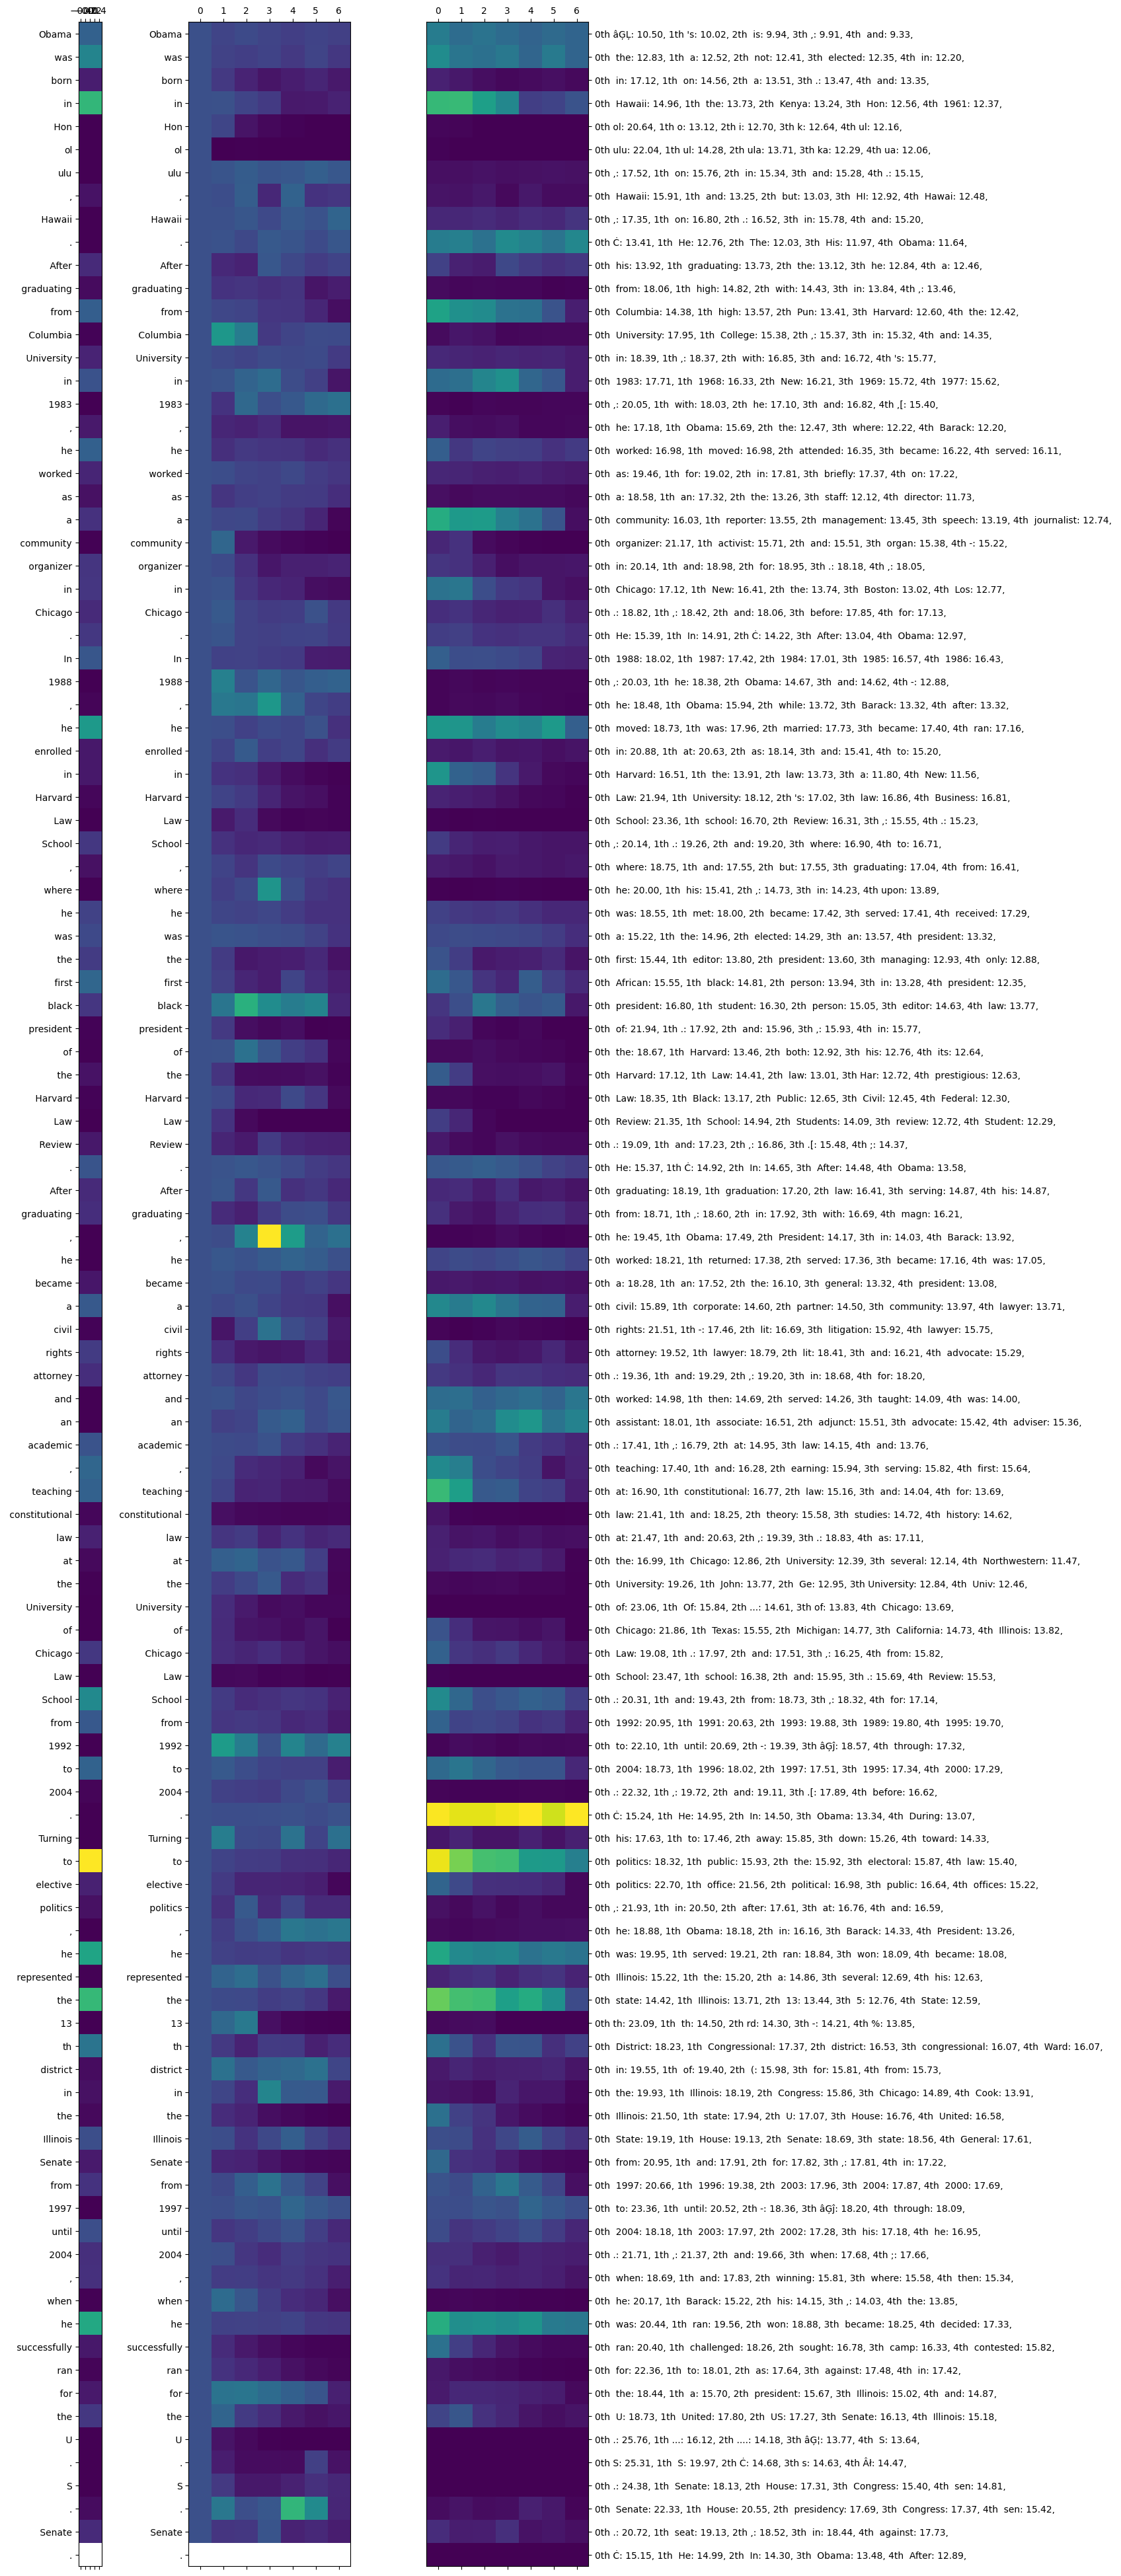

In [12]:
doc_tok = [x.replace('Ġ',' ') for x in tokenizer.tokenize(doc)]
#fig, (ax1, ax2) = plt.subplots(1,2)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(len(doc_tok)/10,50), gridspec_kw={'width_ratios': [3, 7, 7]})
#plt.figure().set_figwidth(10)
ax1.matshow(uncertainty_score)
ax1.set_yticks(np.arange(len(doc_tok)), doc_tok) 
ax2.matshow(entropy_matrix_norm)
ax2.set_yticks(np.arange(len(doc_tok)), doc_tok) 
#plt.yticks(np.arange(len(doc_tok)), doc_tok, rotation='vertical') 
ax3.yaxis.tick_right()
ax3.matshow(entropy_matrix)
ax3.yaxis.set_label_position("right")
ax3.set_yticks(np.arange(len(doc_tok)), top_str_arr[-1]) 



plt.show()

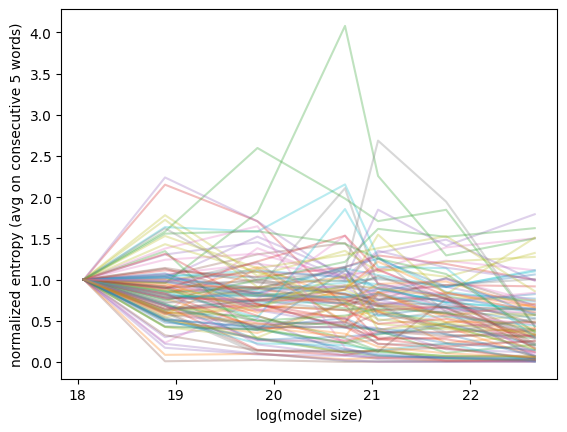

In [13]:
import math
model_size = [70, 160, 410, 1000, 1400, 2800, 6900]

log_model_size = [math.log(x * 1e6) for x in model_size]

num_w = entropy_matrix.shape[0]

log_model_size_expand = np.tile(log_model_size, (num_w,1) )
#print(log_model_size_expand)
#print(entropy_matrix)
#plt.plot(log_model_size_expand.mean(axis=0),entropy_matrix.mean(axis=0), alpha=0.1)
#plt.plot(log_model_size_expand.T,entropy_matrix.T, alpha=0.1)
#plt.plot(log_model_size_expand.T,entropy_matrix_norm.T, alpha=0.1)

avg_num = 1

remove_size = num_w % avg_num
num_curve = int((num_w - remove_size) / avg_num)

if remove_size > 0:
    log_model_size_avg = log_model_size_expand[:-remove_size]
    #entropy_matrix_avg = entropy_matrix[:-remove_size]
    entropy_matrix_avg = entropy_matrix_norm[:-remove_size]
else:
    log_model_size_avg = log_model_size_expand
    entropy_matrix_avg = entropy_matrix_norm
    #entropy_matrix_avg = entropy_matrix
    
log_model_size_avg = log_model_size_avg.reshape(avg_num, num_curve, -1).mean(axis=0)
entropy_matrix_avg = entropy_matrix_avg.reshape(avg_num, num_curve, -1).mean(axis=0)


plt.plot(log_model_size_avg.T,entropy_matrix_avg.T, alpha=0.3)
plt.xlabel('log(model size)')
#plt.ylabel('entropy (avg on consecutive 5 words)')
plt.ylabel('normalized entropy (avg on consecutive 5 words)')

plt.show()

In [108]:
print(tokenizer.tokenize(doc))

['Obama', 'Ġwas', 'Ġborn', 'Ġin', 'ĠHonolulu', ',', 'ĠHawaii', '.', 'ĠAfter', 'Ġgraduating', 'Ġfrom', 'ĠColumbia', 'ĠUniversity', 'Ġin', 'Ġ1983', ',', 'Ġhe', 'Ġworked', 'Ġas', 'Ġa', 'Ġcommunity', 'Ġorganizer', 'Ġin', 'ĠChicago', '.', 'ĠIn', 'Ġ1988', ',', 'Ġhe', 'Ġenrolled', 'Ġin', 'ĠHarvard', 'ĠLaw', 'ĠSchool', ',', 'Ġwhere', 'Ġhe', 'Ġwas', 'Ġthe', 'Ġfirst', 'Ġblack', 'Ġpresident', 'Ġof', 'Ġthe', 'ĠHarvard', 'ĠLaw', 'ĠReview', '.', 'ĠAfter', 'Ġgraduating', ',', 'Ġhe', 'Ġbecame', 'Ġa', 'Ġcivil', 'Ġrights', 'Ġattorney', 'Ġand', 'Ġan', 'Ġacademic', ',', 'Ġteaching', 'Ġconstitutional', 'Ġlaw', 'Ġat', 'Ġthe', 'ĠUniversity', 'Ġof', 'ĠChicago', 'ĠLaw', 'ĠSchool', 'Ġfrom', 'Ġ1992', 'Ġto', 'Ġ2004', '.', 'ĠTurning', 'Ġto', 'Ġelect', 'ive', 'Ġpolitics', ',', 'Ġhe', 'Ġrepresented', 'Ġthe', 'Ġ13', 'th', 'Ġdistrict', 'Ġin', 'Ġthe', 'ĠIllinois', 'ĠSenate', 'Ġfrom', 'Ġ1997', 'Ġuntil', 'Ġ2004', ',', 'Ġwhen', 'Ġhe', 'Ġsuccessfully', 'Ġran', 'Ġfor', 'Ġthe', 'ĠU', '.', 'S', '.', 'ĠSenate', '.', 'ĠIn', 'Ġ2

In [21]:
model_string = 'gpt2'

tokenizer = GPT2Tokenizer.from_pretrained(model_string)
model = GPT2LMHeadModel.from_pretrained(model_string)
model.eval()
model.to('cuda:0')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [48]:
model_string = 'distilgpt2'

model_distill = GPT2LMHeadModel.from_pretrained(model_string)
model_distill.eval()
model_distill.to('cuda:7')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [49]:
entropy_tensor = word_ent((model_distill, tokenizer), doc, True).cpu()
entropy_arr.append(entropy_tensor)

In [50]:

entropy_arr = []
entropy_tensor = word_ent((model, tokenizer), doc, True).cpu()
entropy_arr.append(entropy_tensor)
#print(sent_scoring((model, tokenizer), doc, True))

In [22]:
model_string = 'gpt2-medium'

model_medium = GPT2LMHeadModel.from_pretrained(model_string)
model_medium.eval()
model_medium.to('cuda:1')


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout)

In [51]:

entropy_tensor = word_ent((model_medium, tokenizer), doc, True).cpu()
entropy_arr.append(entropy_tensor)

In [23]:

model_string = 'gpt2-large'

model_large = GPT2LMHeadModel.from_pretrained(model_string)
model_large.eval()
model_large.to('cuda:2')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout)

In [52]:
entropy_tensor = word_ent((model_large, tokenizer), doc, True).cpu()
entropy_arr.append(entropy_tensor)

In [25]:
model_string = 'gpt2-xl'

model_xl = GPT2LMHeadModel.from_pretrained(model_string)
model_xl.eval()
model_xl.to('cuda:3')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout)

In [53]:
entropy_tensor = word_ent((model_xl, tokenizer), doc, True).cpu()
entropy_arr.append(entropy_tensor)

In [54]:
entropy_matrix = torch.stack(entropy_arr).squeeze().numpy()

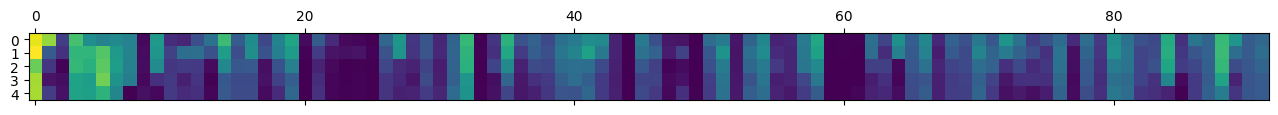

In [55]:

plt.matshow(entropy_matrix)

plt.show()